## Hands-On Physics Informed Neural Networks

- https://medium.com/@hridaym.211me129/hands-on-physics-informed-neural-networks-2e9bca75ab59

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [2]:
import os
import requests
import scipy

def load_data(root_path, file_name):
    path = os.path.join(root_path, file_name)
    if os.path.exists(path):
        print("Data is available.")
    else:
        download_file(path, "data", file_name)
    return scipy.io.loadmat(path)


def download_file(path, folder_name, filename):
    ## https://github.com/rezaakb/pinns-torch/blob/main/pinnstorch/utils/utils.py
    url = f"https://storage.googleapis.com/pinns/{folder_name}/{filename}"
    response = requests.get(url, timeout=10)
    if response.status_code == 200:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "wb") as file:
            file.write(response.content)
        print("File downloaded successfully.")
    else:
        FileNotFoundError("File download failed.")
        
data = load_data(os.getcwd(), "burgers_shock.mat")
print(os.getcwd(), data.keys())

Data is available.
/mnt/d/github/lectures/numerical_analysis/NA-0 dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])


In [31]:
data = scipy.io.loadmat('burgers_shock.mat')
x = data['x']
t = data['t']
u_sol = data['usol'].T
x_size, t_size = x.shape[0], t.shape[0]
print(">> x, t:", x.shape, t.shape)

X, T = np.meshgrid(x, t)
print(">> X, T, U", X.shape, T.shape, u_sol.shape)

>> x, t: (256, 1) (100, 1)
>> X, T, U (100, 256) (100, 256) (100, 256)


In [54]:
# input_X = torch.tensor(X).float().view(-1, 1)
# input_T = torch.tensor(T).float().view(-1, 1)

input_X = torch.tensor(X).flatten()[:, None]
input_T = torch.tensor(T).flatten()[:, None]

train = torch.concat([input_X, input_T], dim=1)
X_min = torch.tensor([-1, 0]).float()
X_max = torch.tensor([1, 1]).float()

input_X.shape, input_T.shape, X_min, X_max

(torch.Size([25600, 1]),
 torch.Size([25600, 1]),
 tensor([-1.,  0.]),
 tensor([1., 1.]))

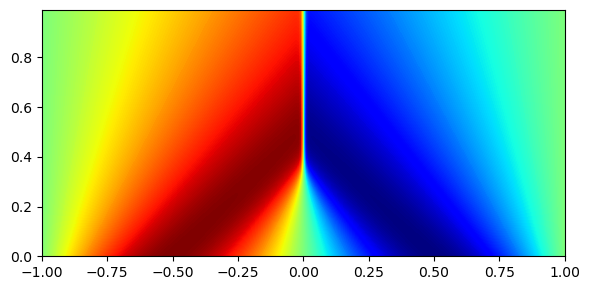

In [55]:
fig, ax = plt.subplots(figsize=(6,3))
# ax.imshow(u_sol, cmap="jet")
ax.contourf(X, T, u_sol, levels=256, cmap="jet")
fig.tight_layout()
plt.show()

In [56]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [57]:
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                        create_graph=True, retain_graph=True)[0]

class PINN():
    def __init__(self, X, u, lb, ub, physics):
        
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        self.physics = physics
        
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float()
        self.u = torch.tensor(u).float()
        
        self.network = Network()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)
        
    def makeNetwork(self, x, t):
        X = torch.cat([x, t], dim=-1)
        return self.network(X)
    
    def residual(self, x, t):
        u = self.makeNetwork(x, t)
        u_t = gradient(u, t)
        u_x = gradient(u, x)
        u_xx = gradient(u_x, x)
        
        return u_t + u*u_x - (0.01/np.pi)*u_xx
    
    def train(self, n_epochs):
        lossTracker = []
        self.network.train()
        for epoch in range(1, n_epochs + 1):
            u_pred = self.makeNetwork(self.x, self.t)
            residual_pred = self.residual(self.x, self.t)
            loss = torch.mean((self.u - u_pred)**2)
            if self.physics == True:
                loss += torch.mean(residual_pred**2)
            lossTracker.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if epoch % (n_epochs // 10) == 0:
                print(f"[{epoch:4d}/{n_epochs}] loss: {loss.item():.2e}")
            
        return lossTracker
            
    def predict(self): 
        self.network.eval()
        u = self.makeNetwork(self.x, self.t)
        res = self.residual(self.x, self.t)
        return u.detach().numpy(), res.detach().numpy()

In [58]:
idx = np.random.choice(train.shape[0], 10000, replace=False)
X_u_train = train[idx, :]
u_train = u_sol.flatten()[:, None][idx,:]

model = PINN(X=X_u_train, u=u_train, lb=X_min[0], ub=X_max[0], physics=True) # Keep False for Vanilla
pinn = model.train(1000)

[ 100/1000] loss: 2.23e-01
[ 200/1000] loss: 1.95e-01
[ 300/1000] loss: 1.94e-01
[ 400/1000] loss: 1.98e-01
[ 500/1000] loss: 2.01e-01
[ 600/1000] loss: 2.03e-01
[ 700/1000] loss: 2.03e-01
[ 800/1000] loss: 2.04e-01
[ 900/1000] loss: 2.04e-01
[1000/1000] loss: 2.04e-01


In [ ]:
u_pred, _ = model.predict()
u_pred = u_pred.reshape()

((2000, 1), torch.Size([2000, 1]), torch.Size([2000, 1]))